In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#from matplotlib import rc
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
import time as time
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Quantifying player 'luck'
We would like to learn a distribution for the number of goals a player should score in a given season based on the shots they took during that season. We can then compare the actual goals scored by each player in each season to our expectations. Players who score more than one standard deviation above their expected number of goals are deemed to be lucky, while players who score more than one standard deviation fewwer than their expected number of goals are deemed to be unluckly. We then examine the relationship between current season luck and changes in goal scoring to subsequent season. 

First we select shot and goal events from the play-by-play data and select for forwards. We drop events for which data is missing.

In [2]:
#Load dataset to a dictionary of dataframes in memory
def load_data(data_dir, filenames):
    dataframes = {}
    for filename in filenames:
        dataframes[filename] = pd.read_csv(data_dir+filename+'.csv')
    return dataframes

filenames = ['game_plays', 'game_plays_players', 'game',
            'game_teams_stats', 'game_shifts' ,'game_skater_stats'
            ,'game_goalie_stats' ,'team_info' ,'player_info']
data_dir = '~/Documents/Employment/Data_incubator/2019_application/Project/data/nhl-game-data/'
dataframes = load_data(data_dir, filenames)

In [3]:
#load event data
game_plays = dataframes['game_plays']
games = dataframes['game'][['game_id','season']]
game_plays_players = dataframes['game_plays_players'][['play_id','player_id','playerType']]
player_info_cut = dataframes['player_info'][['player_id','primaryPosition','birthDate']]
player_info_cut['birthDate'] = pd.to_datetime(player_info_cut['birthDate'])

#consider shots and goals
event_subset = ['Goal','Shot']
game_plays = game_plays[game_plays['event'].isin(event_subset)]

#don't double count events from goalie perspective
game_plays_players = game_plays_players[game_plays_players['playerType'].isin(['Shooter','Scorer'])]

#consider only forwards
player_info_cut = player_info_cut[player_info_cut['primaryPosition']!='D']

#merge tables
plays = pd.merge(game_plays,games,on='game_id')
game_plays_players = pd.merge(game_plays_players,player_info_cut,on='player_id')
plays = pd.merge(plays,game_plays_players,on='play_id')

#map events to class integers
event_dict = {'Goal':1,'Shot':0}
plays['event'] = plays['event'].apply(lambda x: event_dict[x])
#drop nans
plays = plays.dropna()

/Users/tiwariku/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Next, we split the dataframe into a training set and a testing set. We split by player_id, so we have the option to look at season-to-season changes in states for a particular player.

In [4]:
#now we split the dataframe into training and testing. We'll split by player_id
train_size = .5
test_size = .5
players_train, players_test = train_test_split(player_info_cut['player_id'], train_size=train_size,test_size=test_size)
players_test.loc[players_test.index.max()+1] = 8470626 #manually add Loui Eriksson for later
plays_train = pd.merge(players_train,plays,on='player_id')
plays_test = pd.merge(players_test,plays,on='player_id')

## Shot-conditional goal probability
We now build a model to calculate the probability that a shot will be a goal based on its features. We focus on shot position for now:
\begin{align}
P\left(\textrm{Goal}|x,y\right)
\end{align}
We will use a kernelized k nearest-neighbors algorithm to construct this probaiblity distribution using a weighted average of shots from similar locations. We use a Gaussian kernel with standard deviation of 5 feet. If we try to include more shot features with different units, we will have to take care normalizing the data and choosing the covariance matrix of the Gaussian kernel.

In [5]:
#define the KNN model and the custom Gaussian kernel
def knn_kernel(distance):
    return np.exp(-1/(2*(sigma)**2)*np.square(distance))
sigma = 5

my_KNN = KNeighborsClassifier(weights = knn_kernel,n_neighbors=1000)
dump = my_KNN.fit(plays_train[['st_x','st_y']],plays_train['event'])

Our spatially-resolved shooting percentage lends itself well to visualizion. We plot 𝑃(𝐺|𝑥,𝑦) with features of a rink overlayed. 

11.12822699546814


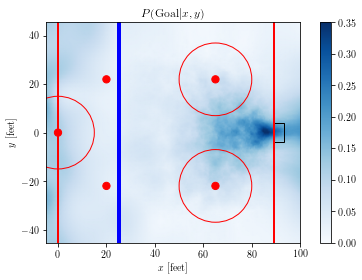

In [6]:
def cmap_on_rink(x,y,z):
    fig, ax = plt.subplots(1)
    cb = ax.pcolormesh(x,y,z,shading='gouraud',cmap='Blues',vmin=0,vmax=.35)#,norm=matplotlib.colors.LogNorm())
    ax.set_xlabel(r'$x$ [feet]')
    ax.set_ylabel(r'$y$ [feet]')
    ax.set_aspect('equal')

    #plot the rink
    plt.axvline(x=25,color='b',linewidth=4)# blue line for offensive zone
    plt.axvline(x=100-11,color='r',linewidth=2)# blue line for offensive zone
    plt.axvline(x=0,color='r',linewidth=2)# blue line for offensive zone
    ax.add_patch(plt.Circle((65,22),15,color='r',fill=False))# faceoff circle
    ax.add_patch(plt.Circle((65,-22),15,color='r',fill=False))# faceoff circle
    ax.add_patch(plt.Circle((65,22),1.5,color='r',fill=True))# faceoff dot
    ax.add_patch(plt.Circle((65,-22),1.5,color='r',fill=True))# faceoff dot
    ax.add_patch(plt.Circle((20,22),1.5,color='r',fill=True))# faceoff dot
    ax.add_patch(plt.Circle((20,-22),1.5,color='r',fill=True))# faceoff dot
    ax.add_patch(plt.Circle((0,0),15,color='r',fill=False))# faceoff circle
    ax.add_patch(plt.Circle((0,0),1.5,color='r',fill=True))# faceoff dot
    goal_loc = matplotlib.patches.Rectangle((89,-4),4.5,8,color='k',fill=False)# the goal
    ax.add_patch(goal_loc)#the goal
    plt.colorbar(cb)#color bar so you can read the plot ~quantitatively
    ax.set_title(r'$P(\textrm{Goal}|x,y)$')
    return fig, ax

#prepare a meshgrid with the spatially-resolved shooting percentage prediction for plotting
start = time.time()
numx = 201 #size of 1/2 of the rink in feet
numy = 171
(xmin,xmax) = (-5,100)
yrad = 45.5
x,y = np.meshgrid(np.linspace(xmin,xmax,numx),np.linspace(-yrad,yrad,numy))
start = time.time()
z_KNN =  np.reshape(my_KNN.predict_proba(np.array([x.ravel(),y.ravel()]).T)[:,1],(numy,numx))
print(time.time()-start)

fig, ax = cmap_on_rink(x,y,z_KNN)
plt.tight_layout()
plt.savefig('Spatially_resolved_KNN.pdf')

Next we calculate the probability that each shot in the testing set will be a goal using the KNN model.

In [7]:
start = time.time()
plays_test['gprobs_KNN'] = my_KNN.predict_proba(plays_test[['st_x','st_y']]).T[1]
print(time.time()-start)

75.20816588401794


## Calculation of player-season luck from shot-goal proabilities

Assuming that the shots are independent, we can calculate the expected number of goals scored by player $p$ in season $i$ as the sum of the expected number of goals over all of their shots using $P\left(G|x,y\right)$:
\begin{align}
\mathbb{E}\left[G_{i,p}\right] = \sum_{s_{i,p}} P\left(G|x_{s_{i,p}},y_{s_{i,p}}\right)
\end{align}
Under the independend-shot assumption, the variance of the this distribiton is also simply given as the sum of the variances for each shot, i.e. $P\left(G|x,y\right)\left(1-P\left(G|x,y\right)\right)$:
\begin{align}
\textrm{Var}\left[G_{i,p}\right] = \sum_{s_{i,p}} P\left(G|x_{s_{i,p}},y_{s_{i,p}}\right)\left(1- P\left(G|x_{s_{i,p}},y_{s_{i,p}}\right)\right)
\end{align}

In [8]:
#function to calculate standard deviation of expected goals distribution
sigmafun = lambda x: np.sqrt(np.sum(x*(1-x)))

#dictionary with aggregation functions to calculate player-season statistics
agg_dict = {'event':{'goals':'sum','shots':'count'},'gprobs_KNN':{'mu':'sum','sigma':sigmafun}}

#perform the aggregation and flatten the columns
player_season_stats = plays_test.groupby(['player_id','season']).agg(agg_dict)
player_season_stats.columns = ['goals','shots','mu','sigma']

#we also aggregate the training data. We want to compare the conditional goal probability to a simple league-average goal probability
player_season_train = plays_train.groupby(['player_id','season']).agg({'event':{'goals':'sum','shots':'count'}})
player_season_train.columns = ['goals','shots']
Gamma = player_season_train['goals'].sum()/player_season_train['shots'].sum()#

#base expected goals model
player_season_stats['mu0'] = player_season_stats['shots']*Gamma
player_season_stats['sigma0'] = np.sqrt(player_season_stats['shots']*(Gamma)*(1-Gamma))

#feature expansion for numer of standadard deviations above or below expected performance
player_season_stats['luck'] = (player_season_stats['goals']-player_season_stats['mu'])/player_season_stats['sigma']
player_season_stats['luck0'] = (player_season_stats['goals']-player_season_stats['mu0'])/player_season_stats['sigma0']

/Users/tiwariku/anaconda/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
/Users/tiwariku/anaconda/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


We are interested in the correlation between our calculated 'luck' parameter and the real season-to-season change in goals scored by forwards. We calculate the difference in goals scored next season and in the current season for each season.

In [9]:
#calculate season-to-season change in goal scoring 
player_season_stats['dgoals'] = player_season_stats.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
player_season_stats['next_goals'] = player_season_stats['goals']+player_season_stats['dgoals']
#player_season_stats_with_last = player_season_stats #save this so we can look at Loui

We then label players who scored more than one standard deviation fewer goals than expected as unlucky and players who exceeded expectations by more than one standard deviation as luckly. We compare the season-to-season change in goals scored for these two populations. 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c15edc4a8>)

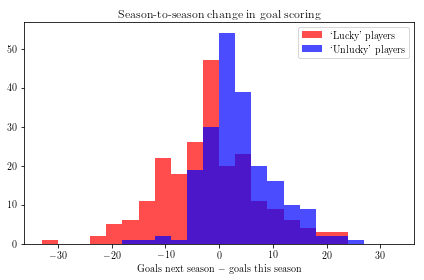

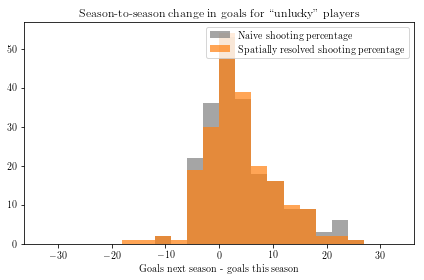

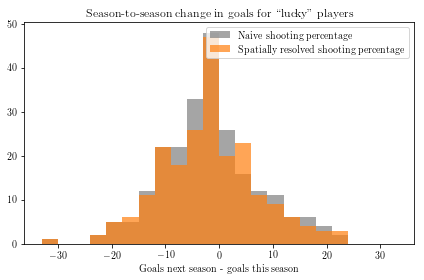

In [10]:
luck_cut = -1
#player_season_stats = player_season_stats[player_season_stats['shots']>100]
underperformers = player_season_stats[player_season_stats['luck']<luck_cut]
underperformers0 = player_season_stats[player_season_stats['luck0']<luck_cut]
overperformers = player_season_stats[player_season_stats['luck']>-luck_cut]
overperformers0 = player_season_stats[player_season_stats['luck0']>-luck_cut]

def get_mean_std(series):
    return series.mean(), series.std()

def histogram_series(series_dict,xlabel='',ylabel='',title=''):
    plt.rc('text', usetex=True)
    bmin = -33
    bmax = 33
    bwidth = 3
    bins = range(bmin,bmax+bwidth,bwidth)#10
    lw = 2
    
    alpha = .7
    fig,ax = plt.subplots(1)
    for key in series_dict.keys():
        series = series_dict[key]['series']
        mean,std = get_mean_std(series)
        label = series_dict[key]['label']
        kwargs = series_dict[key]['kwargs']
        plt.hist(series,bins=bins,label=label,alpha=alpha,**kwargs)
        #plt.axvline(x=mean,linewidth=lw,**kwargs)# blue line for offensive zone
        #plt.axvline(x=mean-std,linewidth=2,**kwargs)# blue line for offensive zone
        #plt.axvline(x=mean+std,linewidth=2,**kwargs)# blue line for offensive zone
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.savefig(title+'.pdf')
    return fig,ax


overunder_compare_dict = {'over':{'series':overperformers['dgoals'],
                                  'label':"`Lucky' players",
                                  'kwargs':{'color':'r'}},
                            'under':{'series':underperformers['dgoals'],
                                     'label':"`Unlucky' players",
                                     'kwargs':{'color':'b'}}
                         }
underperfomer_dict = {'base':{'series':underperformers0['dgoals'],
                              'label':'Naive shooting percentage',
                              'kwargs':{'color':'tab:gray'}},
                      'resolved':{'series':underperformers['dgoals'],
                                  'label':'Spatially resolved shooting percentage',
                                  'kwargs':{'color':'tab:orange'}}
                     }
overperfomer_dict = {'base':{'series':overperformers0['dgoals'],
                             'label':'Naive shooting percentage',
                             'kwargs':{'color':'tab:gray'}},
                     'resolved':{'series':overperformers['dgoals'],
                                 'label':'Spatially resolved shooting percentage',
                                 'kwargs':{'color':'tab:orange'}}
                    }
histogram_series(overunder_compare_dict,title='Season-to-season change in goal scoring',xlabel=r'Goals next season $-$ goals this season')
histogram_series(underperfomer_dict,title='Season-to-season change in goals for ``unlucky" players',xlabel='Goals next season - goals this season')
histogram_series(overperfomer_dict,title='Season-to-season change in goals for ``lucky" players',xlabel='Goals next season - goals this season')

Loui Eriksson is near, but not dear, to my heart. We chart his 'luck' parameter here as a function of season. In the season before he signed his 36 million dollar contract with the Canucks, he exceeded goal-scoring expectations by 1.8 standard deviations. To his defense, our model indicates that he was unlucky in the following seasons.

In [11]:
player_info = dataframes['player_info']
loui_info = player_info[player_info['lastName'] == 'Eriksson']
loui_info = player_info[player_info['firstName'] == 'Loui']
pd.merge(player_season_stats.reset_index(),loui_info,on='player_id')[['firstName','lastName','season','goals','shots','mu','sigma','luck']]

,firstName,lastName,season,goals,shots,mu,sigma,luck
0,Loui,Eriksson,20122013,12,102,12.908691,3.274713,-0.277487
1,Loui,Eriksson,20132014,12,136,14.636929,3.533639,-0.746236
2,Loui,Eriksson,20142015,22,168,20.172013,4.120569,0.443625
3,Loui,Eriksson,20152016,28,172,20.490678,4.163934,1.803420
4,Loui,Eriksson,20162017,11,128,15.782687,3.636258,-1.315277
5,Loui,Eriksson,20172018,10,99,11.770854,3.139266,-0.564098


We can perform a chi-squared analysis to argue that season-to-season change in goal scoring is correlated to luck. We find $p=8\times 10^{-13}$ for the null hypothesis.

In [12]:
#chi squared: can we reject the hypothesis that season-to-season change in goal scoring is independent of current season luck.
#improvers score more goals next season
#regressors score fewer goals next season
#unlucky players scored more than one standard deviation fewer than their expected goals
#lucky players scored more than one standard deviation more than their expected goals

unlucky_regressors = underperformers[underperformers['dgoals']<0]['goals'].count()
unlucky_improvers = underperformers[underperformers['dgoals']>0]['goals'].count()
unlucky_total = unlucky_regressors+unlucky_improvers
lucky_regressors = overperformers[overperformers['dgoals']<0]['goals'].count()
lucky_improvers = overperformers[overperformers['dgoals']>0]['goals'].count()
lucky_total = lucky_regressors+unlucky_improvers

totalregressors = player_season_stats[player_season_stats['dgoals']<0]['goals'].count()
totalimprovers = player_season_stats[player_season_stats['dgoals']>0]['goals'].count()

null_regression_probability = totalregressors/(totalregressors+totalimprovers)
null_improvement_probability = totalimprovers/(totalregressors+totalimprovers)

expected_unlucky_improvers = unlucky_total*null_improvement_probability
expected_lucky_improvers = lucky_total*null_improvement_probability

chi2,p = stats.chisquare([unlucky_improvers,lucky_improvers],[expected_unlucky_improvers,expected_lucky_improvers])
print((chi2,p))

(51.218312393344206, 8.264406687842912e-13)


# Appendix: exploratory data analysis for forecasting goal-scoing
This is rough work. It is probably unclear and is not well commented 

In [13]:
#this table contains skater stats for each game, we will use it to 
#construct forward stats by season including features not tracked by the play-by-play data
game_skater_stats = dataframes['game_skater_stats']#[['game_id','player_id','goals','assists','shots','timeOnIce','hits']]

#We need to join with the game info table so we can sort by season.
#This will also allow us to consider only regular season games.
game_cut = dataframes['game'][['game_id', "date_time",'season', 'type']]#to calculate player age
game_cut = game_cut[game_cut['type']=='R'][['game_id','date_time','season']]#remove playoffs

#We will also join with the player table so we can isolate forwards
#and calculate age
player_info_cut = dataframes['player_info'][['player_id','birthDate','primaryPosition']]
player_info_cut = player_info_cut[player_info_cut['primaryPosition']!='D'][['player_id','birthDate']]

#now we perform the joins
game_forward_stats = pd.merge(game_skater_stats, game_cut, on='game_id')
game_forward_stats = pd.merge(game_forward_stats, player_info_cut, on='player_id')

In [14]:
#next we want to calculate the variables of interest
#we will calculate the age of each player at each game 
#and then average to find their 'age' when grouping by season
#we have ignored leap years
game_forward_stats['date_time'] = pd.to_datetime(game_forward_stats['date_time'],utc=True)
game_forward_stats['birthDate'] = pd.to_datetime(game_forward_stats['birthDate'],utc=True)
game_forward_stats['age'] = (game_forward_stats['date_time']-game_forward_stats['birthDate']).dt.days/365

In [15]:
#now we are in a position to group by player and season 
agg_dict= {'goals':np.sum,'assists':np.sum,'shots':np.sum,'shortHandedTimeOnIce':np.sum,'powerPlayTimeOnIce':np.sum,'evenTimeOnIce':np.sum,'timeOnIce':np.sum,'hits':np.sum,'age':np.mean}
group_by_keys = ['player_id','season']
season_forward_stats = game_forward_stats.groupby(group_by_keys).agg(agg_dict)

#finally, we may make the feature expansion from the base variables
#to an expanded set of variables that we might be interested in. Some of 
#these expanded variables are non-linear in the initial set of variables, so 
#this proceedure goes beyond what may be done with principal componenet 
#analysis. We can then perform a lasso regression to find a dimensionally 
#reduced set of important variables.

#goals scored in the following season:
season_forward_stats['next_goals'] = season_forward_stats.groupby(['player_id'])['goals'].apply(lambda x: x-x.diff(periods=-1))
#change in goals scored from this season to next
season_forward_stats['dgoals'] = season_forward_stats.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
#time on ice in hours (a full game = 1 hour, top forwards usually play ~22 min a game)
season_forward_stats['ppTOI'] = season_forward_stats['powerPlayTimeOnIce'].apply(lambda x: x/3600)
season_forward_stats['esTOI'] = season_forward_stats['evenTimeOnIce'].apply(lambda x: x/3600)
season_forward_stats['shTOI'] = season_forward_stats['shortHandedTimeOnIce'].apply(lambda x: x/3600)
season_forward_stats['TOI'] = season_forward_stats['timeOnIce'].apply(lambda x: x/3600)
season_forward_stats['next_TOI'] = season_forward_stats.groupby(['player_id'])['TOI'].apply(lambda x: x-x.diff(periods=-1))
#goals per shot
season_forward_stats['gps'] = season_forward_stats['goals']/season_forward_stats['shots']
#goals per 60 minutes of ice time
season_forward_stats['gp60'] = season_forward_stats['goals']/season_forward_stats['TOI']
#next season goals per 60
season_forward_stats['next_gp60'] = season_forward_stats['next_goals']/season_forward_stats.groupby(['player_id'])['TOI'].apply(lambda x: x-x.diff(periods=-1))
#change in goals per 60 to next season
season_forward_stats['dgp60'] = season_forward_stats['next_gp60']-season_forward_stats['gp60']
#shots per 60 minutes of ice time
season_forward_stats['sp60'] = season_forward_stats['shots']/season_forward_stats['TOI']


#we also don't want to worry about fringe players. Players who might have
#only played a few games, but happened to score will skew data normalized
#icetime or other cumulative statistics

time_cutoff = 2
season_forward_stats = season_forward_stats[season_forward_stats['TOI']>time_cutoff]
season_forward_stats = season_forward_stats[season_forward_stats['next_TOI']>time_cutoff]

age_cutoff = 22
season_forward_stats = season_forward_stats[season_forward_stats['age']>age_cutoff]


#naive expected goals/shot is just goals/shots averaged over the player-seasons
xgps_0 = season_forward_stats['gps'].mean()
#add a column that's deviation from expected shooting percentage
season_forward_stats['gps-xgps_0'] = season_forward_stats['gps']-xgps_0
season_forward_stats['xgoals'] = season_forward_stats['shots']*xgps_0
season_forward_stats['sigma_xgoals'] = np.sqrt(season_forward_stats['shots']*xgps_0*(1-xgps_0))
season_forward_stats['next_xgoals'] = season_forward_stats.groupby(['player_id'])['xgoals'].apply(lambda x: x-x.diff(periods=-1))
season_forward_stats['luck'] = (season_forward_stats['goals'] - season_forward_stats['xgoals'])/season_forward_stats['sigma_xgoals']
season_forward_stats['dgoals_normalized'] = season_forward_stats['dgoals']/season_forward_stats['sigma_xgoals']

season_forward_stats['xgp60'] = season_forward_stats['xgoals']/season_forward_stats['TOI']
season_forward_stats['next_xgp60'] = season_forward_stats['next_xgoals']/season_forward_stats['next_TOI']

season_forward_stats['goals-xgoals'] = season_forward_stats['goals']-season_forward_stats['xgoals']
season_forward_stats['next_goals-xgoals'] = season_forward_stats['next_goals']-season_forward_stats['xgoals']

#we won't have future goals data for the most recent season
season_forward_stats = season_forward_stats.dropna()

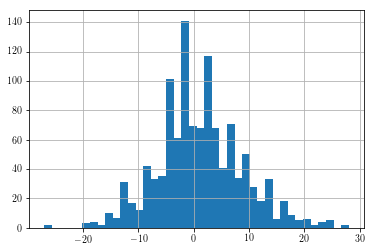

In [16]:
season_forward_stats['dgoals'].hist(bins=40)

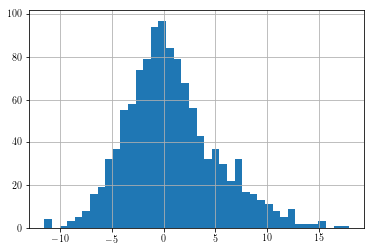

In [17]:
season_forward_stats['goals-xgoals'].hist(bins=40)

In [18]:
def regress_and_plot(xdata,ydata,xlabel='',ylabel='',ax=None):
    plt.rc('text', usetex=False)
    if ax == None:
        fig,ax = plt.subplots(1)
    m, b, r, p, stderr = stats.linregress(xdata,ydata)
    ax.plot(xdata,ydata,'k.')
    ax.plot(xdata,m*xdata+b,'b-')
    ax.set_title('{} vs {}\nr^2 = {}, p = {}\n'.format(ylabel,xlabel,r**2,p))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

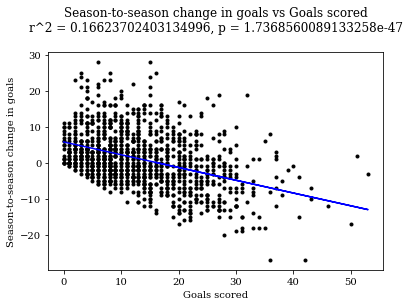

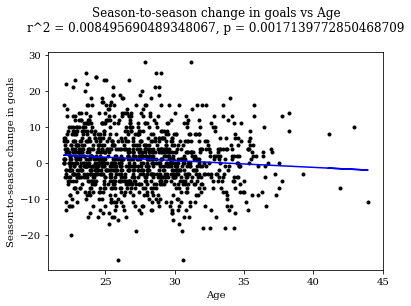

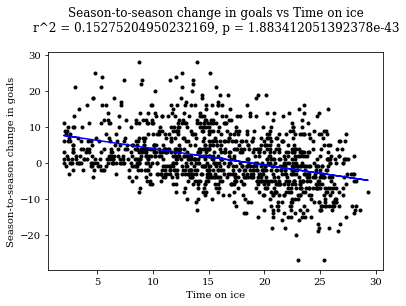

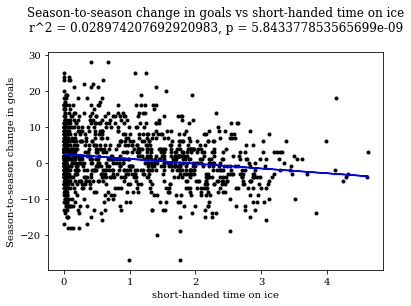

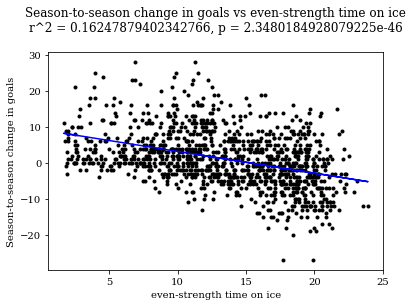

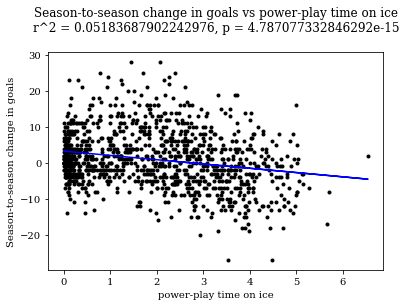

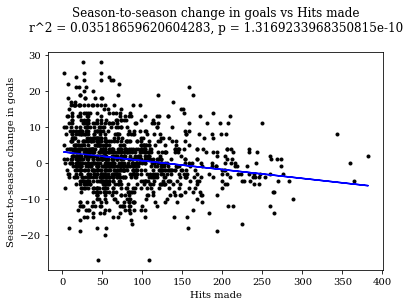

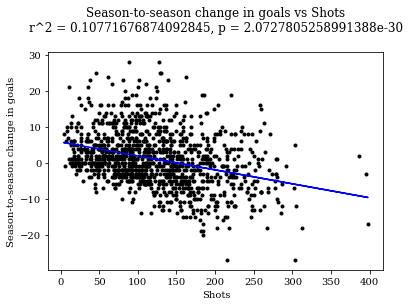

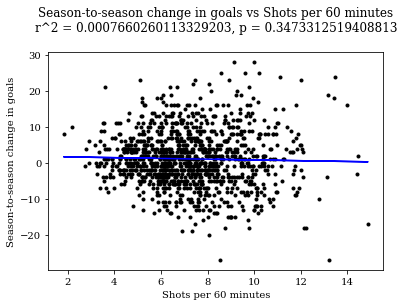

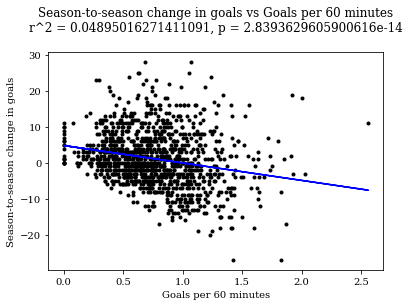

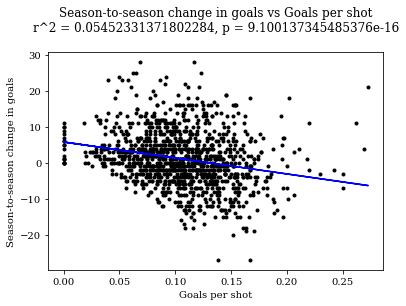

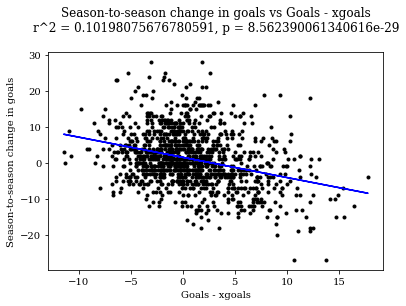

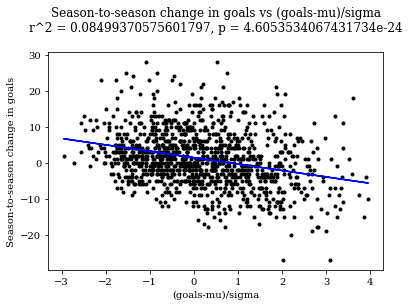

In [19]:
#now we want examine the relationship of these variable to next season's goals
ydata = season_forward_stats['dgoals'].values
ylabel = 'Season-to-season change in goals'

xlabels = {#'dgp60':'Season-to-season change in goals per 60',
        'goals':'Goals scored',
        'age':'Age',
        'TOI':'Time on ice',
        'shTOI':'short-handed time on ice',
        'esTOI':'even-strength time on ice',
        'ppTOI':'power-play time on ice',
        'hits':'Hits made',
        'shots':'Shots',
        'sp60':'Shots per 60 minutes',
        'gp60':'Goals per 60 minutes',
        'gps':'Goals per shot',
        'goals-xgoals':'Goals - xgoals',
        'luck':'(goals-mu)/sigma'}

for key in xlabels.keys():
    xdata = season_forward_stats[key]
    xlabel = xlabels[key]
    regress_and_plot(xdata,ydata,xlabel,ylabel)

In [20]:
#we now perform a lasso regression with our feature expansion
#first we look at an unconstrained linear regression
season_forward_normalized = (season_forward_stats - season_forward_stats.mean())/season_forward_stats.std()
train_size = .5
season_forward_y = season_forward_normalized[['dgoals']]
feature_list = ['luck','esTOI','ppTOI']#['ppTOI','esTOI','shots','sp60','xgoals-goals']
season_forward_X = season_forward_normalized[feature_list]
#season_forward_X = sm.add_constant(season_forward_X)
season_forward_y_train,season_forward_y_test,season_forward_X_train,season_forward_X_test = train_test_split(season_forward_y, season_forward_X, train_size=train_size)
ulr = sm.OLS(season_forward_y_train,season_forward_X_train).fit()
llr = sm.OLS(season_forward_y_train,season_forward_X_train).fit()
mlp = MLPRegressor(hidden_layer_sizes = (len(feature_list),10),max_iter = 10000)
mlp.fit(season_forward_X_train, season_forward_y_train)
print(mlp.score(season_forward_X_test, season_forward_y_test))
ulr.summary()

/Users/tiwariku/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/tiwariku/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2324370397682426


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dgoals   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     61.94
Date:                Wed, 20 Feb 2019   Prob (F-statistic):           1.05e-34
Time:                        15:32:34   Log-Likelihood:                -744.84
No. Observations:                 577   AIC:                             1496.
Df Residuals:                     574   BIC:                             1509.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
luck          -0.2435      0.041     -6.010      0.000      -0.323      -0.164
esTOI         -0.5728      0.055    -10.363      0.000      -0.681      -0.464
ppTOI          0.2736      0.057      4.777      0.000       0.161       0.386
==============================================================================
Omnibus:                       24.629   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.674
Skew:                           0.499   Prob(JB):                     1.61e-06
Kurtosis:                       3.337   Cond. No.                         2.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#feature expansion from 
player_season_stats = pd.merge(player_season_stats,season_forward_stats.reset_index()[['player_id','season','TOI','esTOI','ppTOI','age']],on=['player_id','season'])
player_season_stats['dTOI'] = player_season_stats.groupby(['player_id'])['TOI'].apply(lambda x: -x.diff(periods=-1))
player_season_stats['dppTOI'] = player_season_stats.groupby(['player_id'])['ppTOI'].apply(lambda x: -x.diff(periods=-1))

player_season_stats['gp60'] = player_season_stats['goals']/player_season_stats['TOI']
player_season_stats['dgoals'] = player_season_stats.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
player_season_stats['dgp60'] = player_season_stats.groupby(['player_id'])['gp60'].apply(lambda x: -x.diff(periods=-1))
player_season_stats['next_goals'] = player_season_stats['goals']+player_season_stats['dgoals']
player_season_stats['luck'] = (player_season_stats['goals']-player_season_stats['mu'])/player_season_stats['sigma']
player_season_stats['luck0'] = (player_season_stats['goals']-player_season_stats['mu0'])/player_season_stats['sigma0']


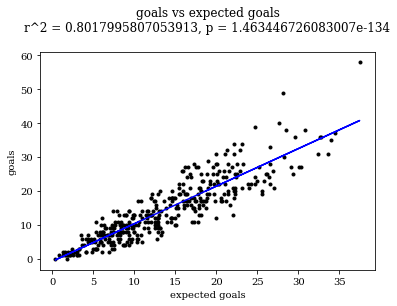

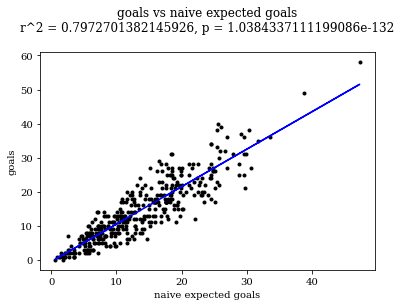

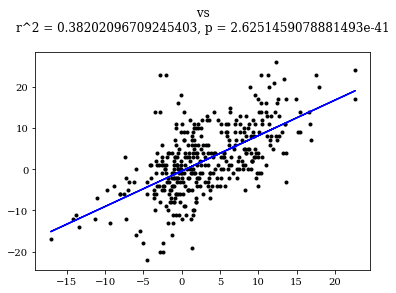

In [22]:
player_season_stats = player_season_stats.dropna()
yplot = player_season_stats['goals']/player_season_stats['shots']
regress_and_plot(player_season_stats['mu'],player_season_stats['goals'],xlabel='expected goals',ylabel='goals')
regress_and_plot(player_season_stats['mu0'],player_season_stats['goals'],xlabel='naive expected goals',ylabel='goals')
regress_and_plot(player_season_stats['dTOI'],player_season_stats['dgoals'])

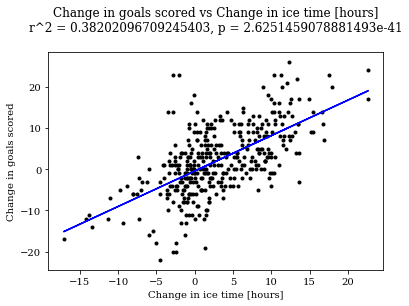

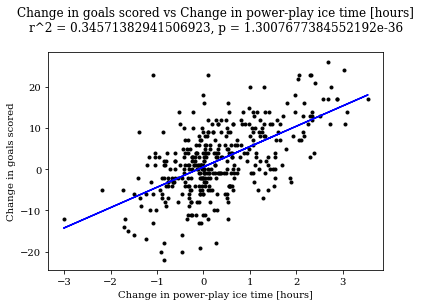

In [23]:
regress_and_plot(player_season_stats['dTOI'],player_season_stats['dgoals'],xlabel='Change in ice time [hours]',ylabel='Change in goals scored')
regress_and_plot(player_season_stats['dppTOI'],player_season_stats['dgoals'],xlabel='Change in power-play ice time [hours]',ylabel='Change in goals scored')

This is a rough sketch of the approach I hope to take overall in forecasting goal scoring:

The goal of this project is to predict the number of goals an NHL player will score next season. We will determine a distribution for the probability that a player will score a certain number of goals next season based on the shots and plays they made in the current season. 

We assume that the player's actual goal total for a season is drawn from a distribution whose mean and variance which reflect the underlying quality of the player. Based on a players shots take in the current season, we determine this mean goals parameter as well as the varience for each player. Then, using existing season-to-season data we forecast the mean and variance of each player's goal scoring distributions for next season based on factors such as player age, ice-time, and current mean and variance. As a result, we determine goal-scoring distributions for the next season for each player. 

We may use the current-season goal-scoring distributions and actual goals scored to identify players that have been unlucky. Then, we may use their next-season goal-scoring distributions to calculate their expected change in goals scored. This calculation will identify players who are expected to improve next season, but are undervalued because of poor actual past performance. It may be possible to sign such players to comparatively inexpensive contracts.


We will assume that the goals a player, $p$, scores during a given season, $i$, are drawn from a distribution with mean $\mu_{i,p}$ and variance $\sigma_{i,p}^2$: 
\begin{align}
G_{i,p} \sim P(G_{i,p}|\mu_{i,p},\sigma_{i,p}^2).
\end{align}
$\mu_{i,p}$ is an underlying expected number of goals the player will score in the season and $\sigma_{i,p}^2$ characterizes our confidence in this 'expected goals.' If we know these parameters, we may make predictions about the performance of player $p$ in season $i$.

Our task is two-fold: we must build a model to learn $\mu_{i,p}$ and $\sigma_{i,p}$ from play-by-play event data, and we must build a model to forecast $\mu_{i+1,p}$ and $\sigma_{i+1,p}$ from a player's current season data. 

First we determine $\mu_{i,p}$ and $\sigma_{i,p}$. As a base model, we assume that goals are simply scored at random from each shot with rate determined by the league-average shooting percentage, $\Gamma$ (total number of goals/ total number of shots). In this case, the season goals distribution is simply a Binomial distribution with mean $\Gamma S_{i,p}$ where $S_{i,p}$ is the number of shots player $p$ took in season $i$:
\begin{align}
P(G_{i,p}|\Gamma,S_{i,p}) =& \begin{pmatrix}S_{i,p}\\G_{i,p}\end{pmatrix}\Gamma^{G_{i,p}}\left(1-\Gamma\right)^{S_{i,p}-G_{i,p}}\\ 
\mu_{i,p} =& \Gamma S_{i,p}\\
\sigma^2_{i,p}=& S_{i,p}\Gamma\left(1-\Gamma\right).
\end{align}
While this approach does give us a distribution, it is overly simplistic. It assumes that all shots are equal, and that a player's goal-scoring is simply a function of the number of shots they take. 
We know that not all shots are equal. One player may find a way to take only shots that have a high probability of being goals, while another player may take many low-probability shots. We know that this information (e.g. shot position) is contained in our play-by-play data, so we take a more sophisticated approach. We use a support vector classifier to construct a distribution 
\begin{align}
P_G\left(s_{i,p}\right),
\end{align}
to calculate the proability that a shot, $s_{i,p}$, will be a goal based on its position, etc...
Using this shot quailty model, we can calculate $\mu_{i,p}$ and $\sigma_{i,p}$ for each player based on their shots. Assuming that the goals are uncorrelated events,
the expected number of goals for player $p$ in season $i$ is then
\begin{align}
\mu_{i,p} = \sum_{s_{i,p}}P_{G}\left(s_{i,p}\right),
\end{align}
and the variance is
\begin{align}
\sigma_{i,p}^2 = \sum_{s_{i,p}}P_G\left(s_{i,p}\right)\left(1-P_G\left(s_{i,p}\right)\right).
\end{align}
We then assume that the the goal total for a player season is drawn from a gamma distribution, a generalization of the Poisson distribition for inhomogeneous rates, characterized by this mean and variance:
\begin{align}
P(G_{i,p}|\alpha_{i,p},\beta_{i,p}) =& \frac{G_{i,p}^{\alpha_{i,p}-1}\beta_{i,p}^{\alpha_{i,p} }e^{-\beta_{i,p}G_{i,p}}}{\Gamma\left(\alpha_{i,p}\right)}\\
\alpha_{i,p} =& \left(\frac{\mu_{i,p}}{\sigma_{i,p}}\right)^2\\
\beta_{i,p} =&\frac{\mu_{i,p}}{\sigma_{i,p}^2}
\end{align}
where $\Gamma\left(\alpha\right)$ is the gamma function.

Our second task is to forecast $\mu_{i+1,p}$ and $\sigma_{i+1,p}$ for future seasons where we don't have the luxury of play-by-play data. This amounts to constructing probability distributions for $\mu_{i+1,p}$ and $\sigma^2_{i+1,p}$ based on each player's current season data:
\begin{align}
P(\mu_{i+1}|\mu_{i},\sigma_{i},\textrm{other season stats})\\
P(\sigma^2_{i+1}|\mu_{i},\sigma_{i},\textrm{other season stats}).
\end{align}


Finally, we are in a position to construct the goal-scoring distributions for season $i+1$. We evaluate the integral:
\begin{align}
P\left(G_{i+1,p}|\mu_{i,p},\sigma^2_{i,p},\dots\right) = \int d\mu_{i+1,p}d\sigma^2_{i+1,p} P(G_{i+1,p}|\mu_{i+1,p},\sigma^2_{i+1,p})P(\mu_{i+1}|\mu_{i},\sigma_{i},\dots)P(\sigma^2_{i+1}|\mu_{i},\sigma_{i},\dots),
\end{align}
where all of the relevant conditional distributions have been modeled from the dataset.
